In [1]:
from pandas import read_csv, read_excel, crosstab, DataFrame
from statistics import mean, median
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import fisher_exact
from helpers.plots import labels, theme, show_corelations

In [2]:
theme()

## Load cleaned data

In [3]:
g = read_csv('data/cleaned_answers.csv')
g.head(2)

,Unnamed: 0,index,Timestamp,sex,age,place_of_residence,is_polish_scout,scouting_organization,years_in_scouting,is_instructor,...,MIT_tick_jump_score,MIT_waiting_boreliosis_score,MIT_safe_score,MIT_summer_tick_score,MIT_part_tick_score,MIT_city_score,MIT_clock_score,total_score_without_images,total_score_with_images,score_as_percent
0,0,0,2018/04/27 1:36:27 PM GMT+2,Kobieta,17,Miasto powyżej 100 tys. mieszkańców,True,ZHP,11.0,True,...,1,1,1,1,1,1,1,26.2,26.2,90.344828
1,1,1,2018/04/27 1:43:31 PM GMT+2,Kobieta,18,Miasto powyżej 100 tys. mieszkańców,True,ZHP,5.0,True,...,1,1,0,1,1,1,0,22.9,22.9,78.965517


## Demographic statistics

In [4]:
scouts = g[g.is_polish_scout]
not_scouts = g[g.is_polish_scout == False]

In [5]:
h_mean = mean(scouts['total_score_without_images'])
nh_mean = mean(not_scouts['total_score_without_images'])
g_mean = mean(g['total_score_without_images'])
h_mean, nh_mean, g_mean

(23.55604670558799, 22.2034686172723, 22.692239300783605)

In [6]:
g.place_of_residence.value_counts()

Miasto powyżej 100 tys. mieszkańców     1093
Wieś                                    1016
Miasto do 50 tys. mieszkańców            765
Miasto od 50 do 100 tys. mieszkańców     444
Name: place_of_residence, dtype: int64

### Number of valid participants

In [7]:
participants_n = len(g)
participants_n

3318

### Number of women

In [8]:
g.is_women.describe()

count     3318
unique       2
top       True
freq      2650
Name: is_women, dtype: object

In [9]:
len(g[g.is_women])

2650

Majority participants were women

In [10]:
f'{round((len(g[g.is_women])/len(g))*100, 2)}% of participants were women.'

'79.87% of participants were women.'

### Number of scouts

In [11]:
g.is_polish_scout.describe()

count      3318
unique        2
top       False
freq       2119
Name: is_polish_scout, dtype: object

In [12]:
len(g[g.is_polish_scout])

1199

Only about 1/3 of participants were scouts

In [13]:
f'{round((len(g[g.is_polish_scout])/len(g))*100, 2)}% of participants were scouts.'

'36.14% of participants were scouts.'

### Age of participants

In [14]:
f'Mean age of all participants was: {round(mean(g.age), 2)} years.'

'Mean age of all participants was: 18.22 years.'

In [15]:
f'Median age of all participants was: {median(g.age)} years.'

'Median age of all participants was: 18.0 years.'

Mean and median age of participants are comparable so I expect little skew in the age distribution.

In [16]:
s = g.age.std()

Assuming that age distribution is normal I would expect 95% of participants to be in this age group:

In [17]:
mean(g.age) - 2 * s, mean(g.age) + 2 * s

(15.459466741476184, 20.980557369434003)

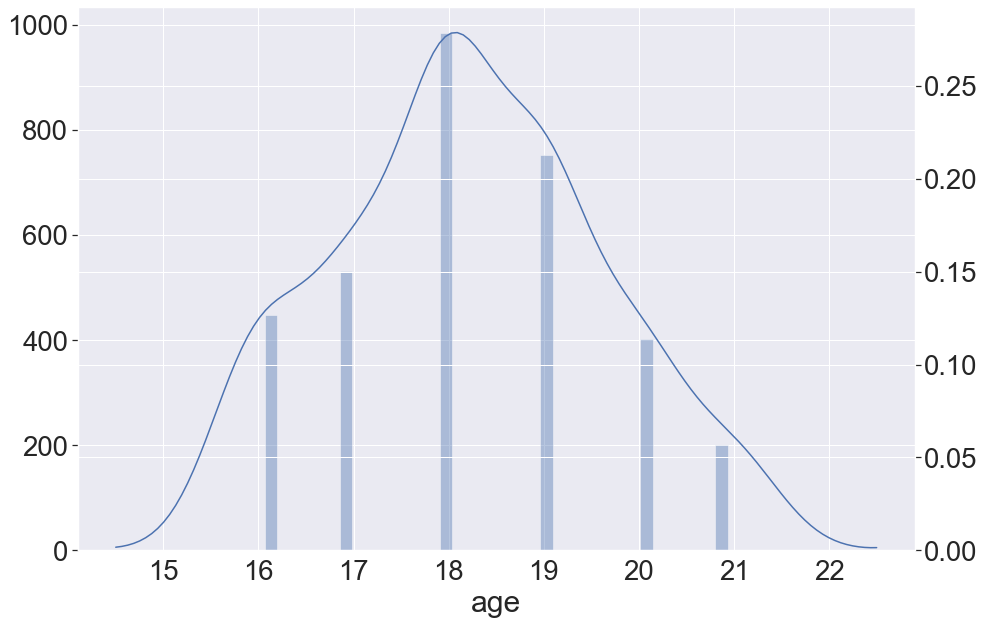

In [18]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.distplot(g.age, kde=False, ax=ax1, hist_kws={'rwidth': 0.5})
sns.distplot(g.age, hist=False, ax=ax2, kde_kws={'bw': .5});

In [19]:
g.age.describe()

count    3318.000000
mean       18.220012
std         1.380273
min        16.000000
25%        17.000000
50%        18.000000
75%        19.000000
max        21.000000
Name: age, dtype: float64

### Age distribution: control group vs Polish population

Those data were used in my master thesis. The data are from 2017 as 2018 data were not available at the time of writing my master thesis. Now I have decided to use 2018 data as they become available.

GUS 2017 and 2018 data comparison is available in the [GUS_17_and_18](GUS_17_and_18.ipynb) notebook.

**Data 2018 source:** [Central Statistical Office in Poland, *Ludność. Stan i struktura oraz ruch naturalny w przekroju terytorialnym w 2018 r. Stan w dniu 31 XII*](https://stat.gov.pl/obszary-tematyczne/ludnosc/ludnosc/ludnosc-stan-i-struktura-oraz-ruch-naturalny-w-przekroju-terytorialnym-w-2018-r-stan-w-dniu-31-xii,6,25.html)


In [20]:
gus_2018_all = read_excel(
    "data/03_ludnosć_struktura wg wieku_RD'2019.xls",
    sheet_name="Tablica 15 ", index_col=0
)

In [21]:
gus_2018_all.iloc[[5, 6]]

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
WIEK \nAGE,Ogółem Total,Mężczyźni Males,Kobiety Females,Miasta Urban areas,NaN,NaN,Wieś Rural areas,NaN,NaN
NaN,NaN,NaN,NaN,razem total,mężczyźni males,kobiety females,razem total,mężczyźni males,kobiety females


In [22]:
gus_2018 = gus_2018_all.loc[range(16, 22)]

In [23]:
gus_2018 = gus_2018.reset_index()
gus_2018.columns = (
    'age total males females city_total city_males '
    'city_females rural_total rural_male rural_female'
).split()
gus_2018.head(2)

,age,total,males,females,city_total,city_males,city_females,rural_total,rural_male,rural_female
0,16,353738,181515,172223,195234,99504,95730,158504,82011,76493
1,17,366102,187690,178412,201651,102767,98884,164451,84923,79528


In [24]:
gus_age = np.repeat(gus_2018.age, gus_2018.total)
gus_age

0    16
0    16
0    16
0    16
0    16
     ..
5    21
5    21
5    21
5    21
5    21
Name: age, Length: 2270127, dtype: int64

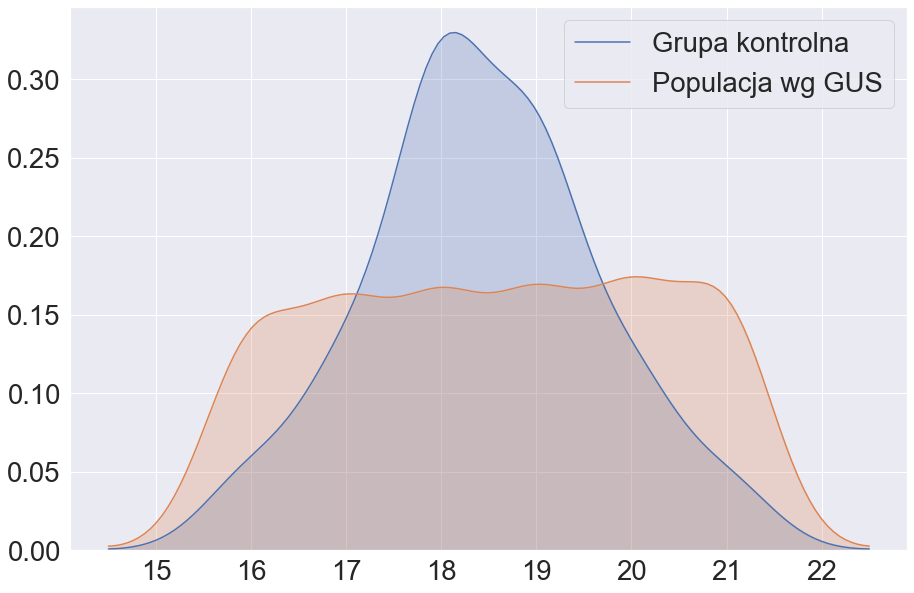

In [25]:
sns.kdeplot(g[~g.is_polish_scout].age, bw=.5, label="Grupa kontrolna", shade=True)
sns.kdeplot(gus_age, bw=.5, label="Populacja wg GUS", shade=True);

Age distribution for all participants was not normal - Shapiro test

In [26]:
stats.shapiro(g.age)

(0.9335240721702576, 3.911832686458745e-36)

### Age distribution: scouts vs control group

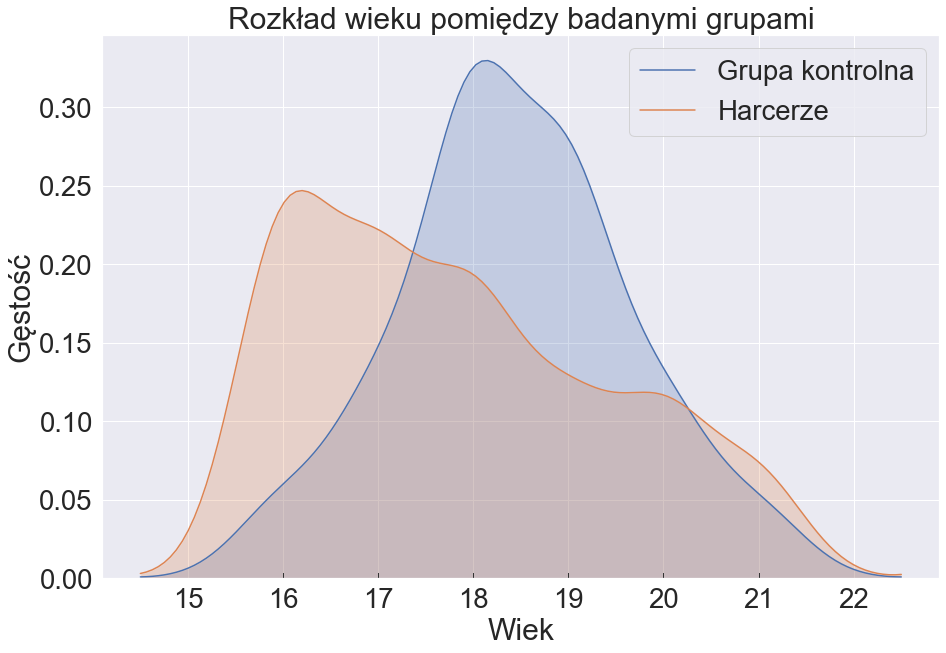

In [27]:
theme()
sns.kdeplot(g[g.is_polish_scout == False].age, bw=.5, label="Grupa kontrolna", shade=True)
sns.kdeplot(g[g.is_polish_scout].age, bw=.5, label="Harcerze", shade=True)
sns.rugplot(g['age'], color='.2', height=0.01)
labels(title='Rozkład wieku pomiędzy badanymi grupami', x='Wiek', y='Gęstość', legend=True)
theme()

ks test sprawdza czy dystrybucje są takie same, im bliżej zera tym większa szansa, że są podobne, im mniejsze pvalue tym bardziej istotne statystycznej

`ks_2samp` p-value is computed more precisely since SciPy 1.3.0 ([stats.ks_2samp changes log](https://docs.scipy.org/doc/scipy/reference/release.1.3.0.html#scipy-stats-improvements)) - see difference in p-value below:

In [28]:
# old
stats.ks_2samp(g[g.is_polish_scout].age, g[g.is_polish_scout == False].age, mode='asymp')

Ks_2sampResult(statistic=0.2993579280515736, pvalue=4.986866046100548e-60)

In [29]:
# new
stats.ks_2samp(g[g.is_polish_scout].age, g[g.is_polish_scout == False].age)

Ks_2sampResult(statistic=0.2993579280515736, pvalue=1.9984014443252818e-15)

z-score = miara efektu, czyli jak ważne

In [30]:
stats.skewtest(g[g.is_polish_scout].age)

SkewtestResult(statistic=6.768283594807245, pvalue=1.303191258197755e-11)

In [31]:
stats.skewtest(g[g.is_polish_scout == False].age)

SkewtestResult(statistic=1.3415458787359742, pvalue=0.17974328450534405)

`scipy.stats.skew`

>For normally distributed data, the skewness should be about 0. A skewness value > 0 means that there is more weight in the left tail of the distribution. The function skewtest can be used to determine if the skewness value is close enough to 0, statistically speaking.

> Returns: The skewness of values along an axis, returning 0 where all values are equal.

Source: [SciPy docs](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.skew.html)

In [32]:
stats.skew(g[g.is_polish_scout].age)

0.5027416352254511

In [33]:
stats.shapiro(g[g.is_polish_scout].age)

(0.8865760564804077, 9.284932937868277e-29)

In [34]:
stats.shapiro(g[g.is_polish_scout == False].age)

(0.9304187297821045, 2.527670204550568e-30)

### Sex distribution comparison

Female to male ratio from GUS 2018 data

In [35]:
t = gus_2018[['males', 'females']].apply(sum)
gus_female_male_ratio = t['females'] / t['males']
print(f'GUS women to men ratio: {round(gus_female_male_ratio, 2)}')

GUS women to men ratio: 0.95


Female to male ratio according to ZHP 2018 data

Data: http://hib.zhp.pl/zhp-w-liczbach/

In my Master Thesis I used data from 2017 (`female_male_ratio_zhp = 1.44`) as 2018 was not available at that time.

In [36]:
zhp_in_numbers = read_excel(
    "data/ZHP_zestawienie_2018.xlsx",
    sheet_name="zestawienie_2018-1", index_col=2
)
zhp_in_numbers.tail(2)

,Data zliczenia,Jednostka,l. ogółem,l. og. K,l. og. M,l. NS K,l. NS M,brak,Obiet. K,Obiet. M,...,HS K,HS M,Wędr K,Wędr M,Wędr/Inst K,Wędr/Inst M,Inst K,Inst M,Sen/Inst K,Sen/Inst M
Kod,,,,,,,,,,,,,,,,,,,,,
1080000000000,2018-01-01,CHORĄGIEW ZIEMI LUBUSKIEJ,2819,1625,1194,158,149,1973,140,100,...,245,179,127,82,155,139,274,241,90,77
Razem:,NaT,NaN,102886,61541,41345,1854,2086,73570,5079,3264,...,11679,7132,5626,3611,5798,4263,7309,5890,2425,1923


In [37]:
zhp_members_total = zhp_in_numbers.loc["Razem:"]
zhp_members_total.head(3)

Data zliczenia       NaT
Jednostka            NaN
l. ogółem         102886
Name: Razem:, dtype: object

In [38]:
zhp_females = zhp_members_total.loc["Wędr K"] + zhp_members_total.loc["Wędr/Inst K"]
zhp_males = zhp_members_total.loc["Wędr M"] + zhp_members_total.loc["Wędr/Inst M"]
zhp_female_male_ratio = zhp_females / zhp_males
print(f'ZHP women to men ratio: {round(zhp_female_male_ratio, 2)}')

ZHP women to men ratio: 1.45


Sex distribution: scouts vs control group

In [39]:
contingency_table = crosstab(g.sex, g.is_polish_scout)
contingency_table

is_polish_scout,False,True
sex,,
Kobieta,1757,893
Mężczyzna,362,306


In [40]:
is_scout_sex = contingency_table.to_dict()

In [41]:
# odds_ratio, pvalue
fisher_exact(contingency_table)

(1.6631566573657608, 9.53996170502642e-09)

pl: Kobieta -> eng: Woman

pl: Mężczyzna -> eng: Man

In [42]:
ct = DataFrame(contingency_table.unstack(), columns=['count']).reset_index()
ct

,is_polish_scout,sex,count
0,False,Kobieta,1757
1,False,Mężczyzna,362
2,True,Kobieta,893
3,True,Mężczyzna,306


pl: Grupa kontrolna -> eng: Contol group

pl: Harcerze -> eng: Scouts

In [43]:
dictionary_is_polish_scout = {
    False: 'Grupa kontrolna',
    True: 'Harcerze'
}
ct.is_polish_scout = ct.is_polish_scout.replace(dictionary_is_polish_scout)
ct.is_polish_scout

0    Grupa kontrolna
1    Grupa kontrolna
2           Harcerze
3           Harcerze
Name: is_polish_scout, dtype: object

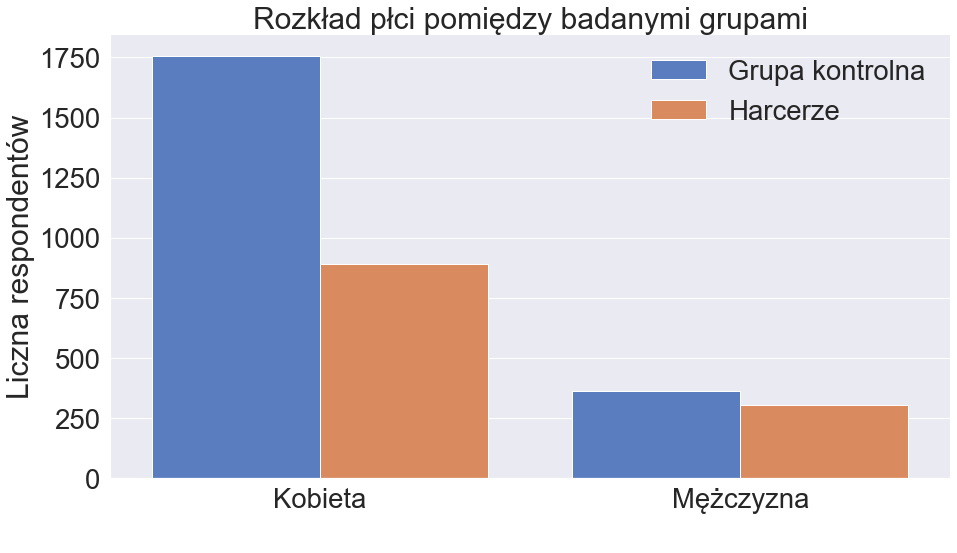

In [44]:
gr = sns.catplot(
    x="sex", y="count", hue="is_polish_scout", data=ct,
    kind="bar", palette="muted", legend=False, height=8, aspect=14 / 8
)
gr.ax.legend(loc='upper right', frameon=False)
labels(title='Rozkład płci pomiędzy badanymi grupami', x=' ', y='Liczna respondentów', legend=False);

In [45]:
is_scout_sex[True]['Kobieta']
no_scout_sex_ratio_w_to_m = (is_scout_sex[False]['Kobieta']) / (is_scout_sex[False]['Mężczyzna'])
scout_sex_ratio_w_to_m = (is_scout_sex[True]['Kobieta']) / (is_scout_sex[True]['Mężczyzna'])
print(
    f'Control group women to men ratio: {round(no_scout_sex_ratio_w_to_m, 2)}\n'
    f'Scouts women to men ratio: {round(scout_sex_ratio_w_to_m, 2)}'
)

Control group women to men ratio: 4.85
Scouts women to men ratio: 2.92


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


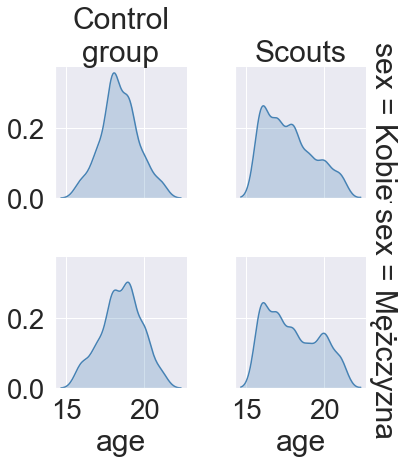

In [46]:
gr = sns.FacetGrid(g, row="sex", col="is_polish_scout", margin_titles=True)
gr.map(sns.kdeplot, "age", color="steelblue", shade=True, bw=0.45);
axes = gr.axes.flatten()
axes[0].set_title("Control\ngroup")
axes[1].set_title("Scouts");

### Place distributipon

In [47]:
table = crosstab(g.place_of_residence, g.is_polish_scout)
table

is_polish_scout,False,True
place_of_residence,,
Miasto do 50 tys. mieszkańców,473,292
Miasto od 50 do 100 tys. mieszkańców,262,182
Miasto powyżej 100 tys. mieszkańców,608,485
Wieś,776,240


In [48]:
t = DataFrame(table.unstack(), columns=['count']).reset_index()

In [49]:
def licz_procent(wiersz):
    return 100 * wiersz['count'] / len(g[g.is_polish_scout == wiersz.is_polish_scout])

In [50]:
t = t.assign(procent_grupy=t.apply(licz_procent, axis='columns'))
t

,is_polish_scout,place_of_residence,count,procent_grupy
0,False,Miasto do 50 tys. mieszkańców,473,22.321850
1,False,Miasto od 50 do 100 tys. mieszkańców,262,12.364323
2,False,Miasto powyżej 100 tys. mieszkańców,608,28.692780
3,False,Wieś,776,36.621048
4,True,Miasto do 50 tys. mieszkańców,292,24.353628
5,True,Miasto od 50 do 100 tys. mieszkańców,182,15.179316
6,True,Miasto powyżej 100 tys. mieszkańców,485,40.450375
7,True,Wieś,240,20.016681


In [51]:
dict_place_of_residence = {
    'Miasto do 50 tys. mieszkańców': 'Miasto\ndo 50 tys.\nmieszkańców',
    'Miasto od 50 do 100 tys. mieszkańców': 'Miasto\nod 50 do 100 tys.\nmieszkańców',
    'Miasto powyżej 100 tys. mieszkańców': 'Miasto powyżej\n100 tys.\nmieszkańców'
}
t.place_of_residence = t.place_of_residence.replace(dict_place_of_residence)
t.place_of_residence

0           Miasto\ndo 50 tys.\nmieszkańców
1    Miasto\nod 50 do 100 tys.\nmieszkańców
2     Miasto powyżej\n100 tys.\nmieszkańców
3                                      Wieś
4           Miasto\ndo 50 tys.\nmieszkańców
5    Miasto\nod 50 do 100 tys.\nmieszkańców
6     Miasto powyżej\n100 tys.\nmieszkańców
7                                      Wieś
Name: place_of_residence, dtype: object

In [52]:
dict_is_polish_scout = {
    False: 'Grupa kontrolna',
    True: 'Harcerze'
}
t.is_polish_scout = t.is_polish_scout.replace(dict_is_polish_scout)
t.is_polish_scout

0    Grupa kontrolna
1    Grupa kontrolna
2    Grupa kontrolna
3    Grupa kontrolna
4           Harcerze
5           Harcerze
6           Harcerze
7           Harcerze
Name: is_polish_scout, dtype: object

In [53]:
t.groupby(t.is_polish_scout).apply
t

,is_polish_scout,place_of_residence,count,procent_grupy
0,Grupa kontrolna,Miasto\ndo 50 tys.\nmieszkańców,473,22.321850
1,Grupa kontrolna,Miasto\nod 50 do 100 tys.\nmieszkańców,262,12.364323
2,Grupa kontrolna,Miasto powyżej\n100 tys.\nmieszkańców,608,28.692780
3,Grupa kontrolna,Wieś,776,36.621048
4,Harcerze,Miasto\ndo 50 tys.\nmieszkańców,292,24.353628
5,Harcerze,Miasto\nod 50 do 100 tys.\nmieszkańców,182,15.179316
6,Harcerze,Miasto powyżej\n100 tys.\nmieszkańców,485,40.450375
7,Harcerze,Wieś,240,20.016681


In [54]:
# replace column name from 'is_polish_scout' to ' '
t.rename(columns={'is_polish_scout': 'group'}, inplace=True)

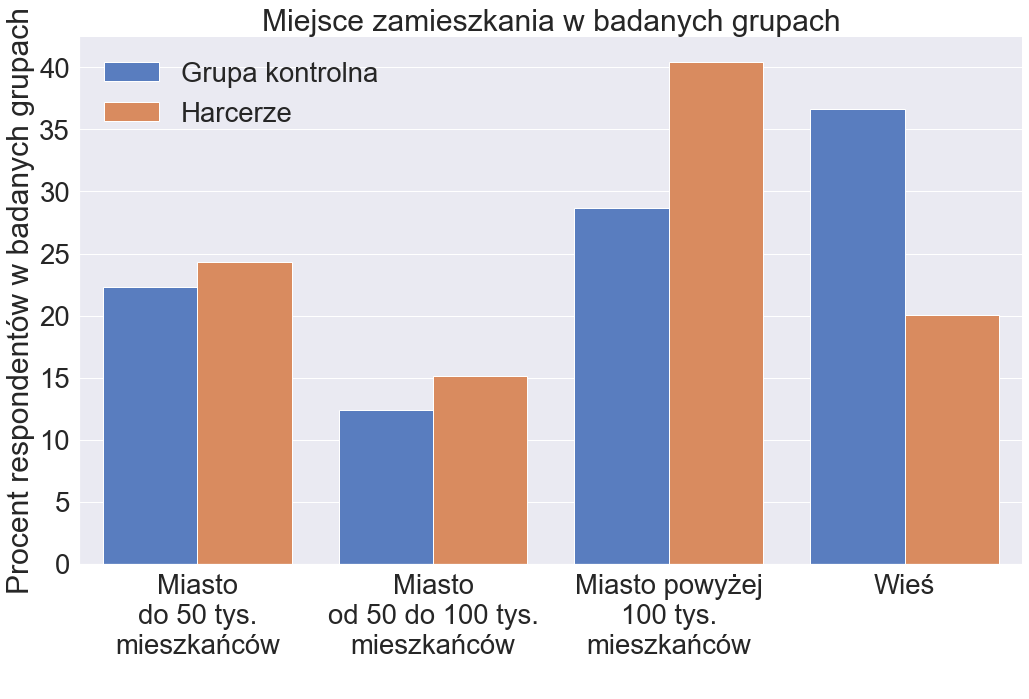

In [55]:
graph = sns.catplot(
    x="place_of_residence", y="procent_grupy", hue="group", data=t,
    kind="bar", palette="muted", aspect=3/2, height=10,
    legend=False
)
graph.ax.legend(loc='upper left', frameon=False)
labels(
    title='Miejsce zamieszkania w badanych grupach',
    x=' ', y='Procent respondentów w badanych grupach',
    legend=False
);

In [56]:
counts = DataFrame(
    g[~g.is_polish_scout].place_of_residence.value_counts().reset_index()
).rename({'index': 'place', 'place_of_residence': 'total'}, axis='columns')
scout_counts = DataFrame(
    g[g.is_polish_scout].place_of_residence.value_counts().reset_index()
).rename({'index': 'place', 'place_of_residence': 'total'}, axis='columns')

control = {
    'miasto': sum(counts[counts.place.str.startswith('Miasto')].total),
    'wieś': counts[counts.place == 'Wieś'].total.iloc[0]
}
control

{'miasto': 1343, 'wieś': 776}

In [57]:
scouts_miejsce = {
    'miasto': sum(scout_counts[scout_counts.place.str.startswith('Miasto')].total),
    'wieś': scout_counts[scout_counts.place == 'Wieś'].total.iloc[0]
}
scouts_miejsce

{'miasto': 959, 'wieś': 240}

In [58]:
control_sum = control['miasto'] + control['wieś']
100 * control['miasto'] / control_sum

63.37895233600755

In [59]:
scouts_sum = scouts_miejsce['miasto'] + scouts_miejsce['wieś']
100 * scouts_miejsce['miasto'] / scouts_sum

79.98331943286071

In [60]:
total_gus = gus_2018[['city_total', 'rural_total']].apply(sum)
total_gus

city_total     1224978
rural_total    1045149
dtype: int64

In [61]:
contingency_table = [
    # all populacja
    [control['miasto'], total_gus.loc['city_total']],   # miasto
    [control['wieś'], total_gus.loc['rural_total']],  # wieś
]

print('Miasto / wieś')
print('Kontrolna', control['miasto'] / control['wieś'])
print('Harcerze', scouts_miejsce['miasto'] / scouts_miejsce['wieś'])
print('GUS', total_gus.loc['city_total'] / total_gus.loc['rural_total'])

stats.fisher_exact(contingency_table), stats.chi2_contingency(contingency_table)

Miasto / wieś
Kontrolna 1.7306701030927836
Harcerze 3.995833333333333
GUS 1.1720606344167195


((1.4766045819413243, 2.189710906452374e-18),
 (75.21164210348219,
  4.228662963292506e-18,
  1,
  array([[1.14361482e+03, 1.22517739e+06],
         [9.75385181e+02, 1.04494961e+06]])))

In [62]:
(control['miasto'] / control['wieś']) / (total_gus.loc['city_total'] / total_gus.loc['rural_total'])

1.4766045819413245

### Demographics corelations

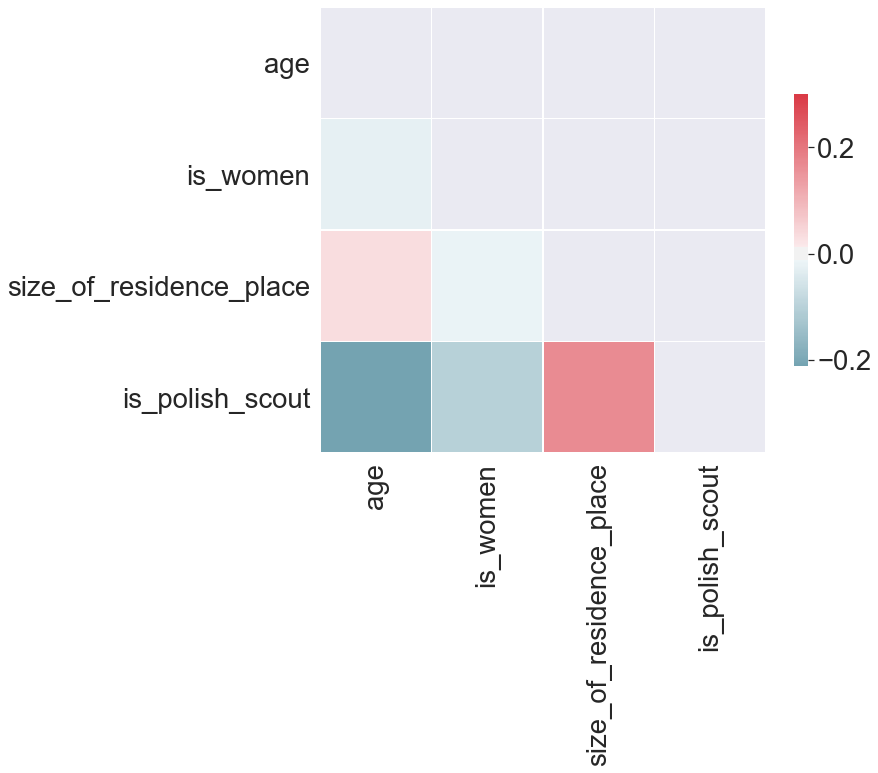

In [63]:
show_corelations(g, only=[
    'age', 'is_women', 'size_of_residence_place', 'is_polish_scout'
])
stats.spearmanr(g.is_polish_scout, g.age);   # średniomaly efekt

In [64]:
stats.spearmanr(g.is_polish_scout, g.size_of_residence_place)

SpearmanrResult(correlation=0.17054533028325766, pvalue=4.481430947347636e-23)

In [65]:
stats.spearmanr(g.is_polish_scout, g.is_women)

SpearmanrResult(correlation=-0.10108574708398545, pvalue=5.362693793812592e-09)